# PRACTICE WITH PYTORCH #02
Nguyễn Anh Thư - 23127266

## 1. Import and Setup


In [151]:
# ==========================================
# Environment Setup (COMMENTED)
# ==========================================
# NOTE: Keep everything commented. Uncomment only when you need it.
#
# Core
# !pip install torch numpy matplotlib
#
# Image IO
# !pip install pillow
# # or: !pip install opencv-python
#
# Download dataset from Kaggle (optional)
# !pip install kagglehub
#
# import os
# import kagglehub
# import shutil
#
# # Download latest version
# path = kagglehub.dataset_download("scolianni/mnistasjpg")
# print("Path to dataset files:", path)
#
# # IMPORTANT: for submission/run-all, dataset folder should be SIBLING of ./source
# # i.e. 23127266_p06_02/mnistasjpg_data
# target_path = os.path.abspath(os.path.join(os.getcwd(), "..", "mnistasjpg_data"))
# if not os.path.exists(target_path):
#     shutil.move(path, target_path)
#     print(f"Dataset moved to: {target_path}")
# else:
#     print(f"Folder {target_path} already exists.")
#
# # Quick check
# # print(os.listdir(target_path))


In [ ]:
import os
import random
from typing import Any

import numpy as np
import torch
import matplotlib.pyplot as plt


# ==========================================================
# PATHS (submission-friendly)
# ==========================================================
# DEV: Uncomment the line below to use dataset from p06_01 during development.
# When done, comment/delete this line and the submission will use the default path.
# DEV_DATASET_PATH = "../../23127266_p06_01/source/mnistasjpg_data"

# Default for submission: dataset is sibling of ./source/
# - Notebook is in: 23127266_p06_02/source/
# - Dataset must be in: 23127266_p06_02/mnistasjpg_data/
_default_dataset_root = os.path.abspath(os.path.join(os.getcwd(), "..", "mnistasjpg_data"))

# Use dev path if set, otherwise use default
_dataset_root = _default_dataset_root
try:
    if 'DEV_DATASET_PATH' in globals() and DEV_DATASET_PATH is not None:
        _dataset_root = os.path.abspath(DEV_DATASET_PATH)
except NameError:
    pass  # DEV_DATASET_PATH not defined, use default

PATHS: dict[str, str] = {
    "dataset_root": _dataset_root,
    "checkpoint": os.path.join(os.getcwd(), "custom_mnist_net.pkl"),
    "single_image": os.path.join(os.getcwd(), "sample_digit.jpg"),
}

def set_global_seed(seed: int) -> None:
    """Set global RNG seeds.

    Args:
        seed: Random seed.

    Returns:
        None

    Raises:
        None
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


set_global_seed(int(CONFIG["seed"]))
print("dataset_root:", CONFIG["dataset_root"])

dataset_root: f:\ANHTHU\1-HCMUS\1 - STUDY\HKVII\DIP\LAB\LAB6\23127266_p06_01\source\mnistasjpg_data


## 2. Activation Functions


In [153]:
class Activation:
    """Activation functions.

    Args:
        None

    Returns:
        None

    Raises:
        None
    """

    @staticmethod
    def sigmoid(x: torch.Tensor) -> torch.Tensor:
        """Compute sigmoid activation.

        Args:
            x: Input tensor.

        Returns:
            torch.Tensor: Activated tensor.

        Raises:
            None
        """
        return 1.0 / (1.0 + torch.exp(-x))

    @staticmethod
    def tanh(x: torch.Tensor) -> torch.Tensor:
        """Compute tanh activation.

        Args:
            x: Input tensor.

        Returns:
            torch.Tensor: Activated tensor.

        Raises:
            None
        """
        return torch.tanh(x)

    @staticmethod
    def relu(x: torch.Tensor) -> torch.Tensor:
        """Compute ReLU activation.

        Args:
            x: Input tensor.

        Returns:
            torch.Tensor: Activated tensor.

        Raises:
            None
        """
        return torch.clamp(x, min=0.0)

    @staticmethod
    def softmax(x: torch.Tensor) -> torch.Tensor:
        """Compute softmax activation (stable version).

        Args:
            x: Input tensor of shape (N, C) where N is batch size, C is number of classes.

        Returns:
            torch.Tensor: Probabilities tensor of shape (N, C) summing to 1 along dim=1.

        Raises:
            ValueError: If input is not 2D.
        """
        if x.dim() != 2:
            raise ValueError("softmax expects 2D tensor of shape (N, C)")

        # Stable softmax: subtract max to prevent overflow
        x_shift = x - torch.max(x, dim=1, keepdim=True).values
        exp_x = torch.exp(x_shift)
        return exp_x / torch.sum(exp_x, dim=1, keepdim=True)


## 3. Activation Derivatives


In [154]:
class ActivationPrime:
    """Activation derivatives for backpropagation.

    Notes:
        `ActivationLayer.backward()` passes the *pre-activation* tensor z into
        these derivative functions.

    Args:
        None

    Returns:
        None

    Raises:
        None
    """

    @staticmethod
    def sigmoid_derivative(z: torch.Tensor) -> torch.Tensor:
        """Compute derivative of sigmoid w.r.t. pre-activation z.

        Args:
            z: Pre-activation tensor.

        Returns:
            torch.Tensor: Derivative tensor with same shape as z.

        Raises:
            None
        """
        sig = Activation.sigmoid(z)
        return sig * (1.0 - sig)

    @staticmethod
    def tanh_derivative(z: torch.Tensor) -> torch.Tensor:
        """Compute derivative of tanh w.r.t. pre-activation z.

        Args:
            z: Pre-activation tensor.

        Returns:
            torch.Tensor: Derivative tensor with same shape as z.

        Raises:
            None
        """
        t = torch.tanh(z)
        return 1.0 - t**2

    @staticmethod
    def relu_derivative(z: torch.Tensor) -> torch.Tensor:
        """Compute derivative of ReLU w.r.t. pre-activation z.

        Args:
            z: Pre-activation tensor.

        Returns:
            torch.Tensor: Derivative tensor with same shape as z.

        Raises:
            None
        """
        return (z > 0).to(z.dtype)

    @staticmethod
    def softmax_derivative(z: torch.Tensor, out_error: torch.Tensor) -> torch.Tensor:
        """Compute gradient through softmax layer.

        For softmax: s = softmax(z)
        When receiving gradient dL/ds, compute dL/dz:
            dL/dz_i = sum_j (dL/ds_j * ds_j/dz_i)
            where ds_j/dz_i = s_j * (delta_ij - s_i)

        This simplifies to:
            dL/dz = s * (dL/ds - sum(dL/ds * s))

        Args:
            z: Pre-activation tensor of shape (N, C).
            out_error: Gradient dL/ds (w.r.t. softmax output) of shape (N, C).

        Returns:
            torch.Tensor: Gradient dL/dz (w.r.t. pre-activation) of shape (N, C).

        Raises:
            ValueError: If inputs are not 2D or shapes don't match.
        """
        if z.dim() != 2 or out_error.dim() != 2:
            raise ValueError("softmax_derivative expects 2D tensors")
        if z.shape != out_error.shape:
            raise ValueError(f"Shape mismatch: z={z.shape}, out_error={out_error.shape}")

        s = Activation.softmax(z)
        # dL/dz = s * (dL/ds - sum(dL/ds * s, dim=1, keepdim=True))
        sum_term = torch.sum(out_error * s, dim=1, keepdim=True)
        return s * (out_error - sum_term)


## 4. Loss Functions


In [155]:
class Loss:
    """Loss functions.

    Args:
        None

    Returns:
        None

    Raises:
        None
    """

    @staticmethod
    def mse(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
        """Compute Mean Squared Error (MSE).

        Args:
            y_true: Ground-truth tensor.
            y_pred: Predicted tensor.

        Returns:
            torch.Tensor: Scalar loss tensor.

        Raises:
            None
        """
        return torch.mean((y_true - y_pred) ** 2)

    @staticmethod
    def cross_entropy_with_logits(y_true_int: torch.Tensor, logits: torch.Tensor) -> torch.Tensor:
        """Compute cross-entropy loss from logits (multi-class).

        This matches the stable formulation:
            loss = mean(logsumexp(logits) - logits[y_true])

        Args:
            y_true_int: Integer class labels of shape (N,) or (1,).
            logits: Raw logits of shape (N, C) or (1, C).

        Returns:
            torch.Tensor: Scalar loss tensor.

        Raises:
            ValueError: If logits is not 2D.
        """
        if logits.dim() != 2:
            raise ValueError("logits must be a 2D tensor with shape (N, C)")

        y = y_true_int.view(-1).to(torch.long)
        n = logits.shape[0]
        log_z = torch.logsumexp(logits, dim=1)
        correct = logits[torch.arange(n, device=logits.device), y]
        return torch.mean(log_z - correct)

    @staticmethod
    def cross_entropy(y_true_int: torch.Tensor, probs: torch.Tensor) -> torch.Tensor:
        """Compute cross-entropy loss from probabilities (multi-class).

        Args:
            y_true_int: Integer class labels of shape (N,) or (1,).
            probs: Probability tensor of shape (N, C) (should sum to 1 along dim=1).

        Returns:
            torch.Tensor: Scalar loss tensor.

        Raises:
            ValueError: If probs is not 2D.
        """
        if probs.dim() != 2:
            raise ValueError("probs must be a 2D tensor with shape (N, C)")

        y = y_true_int.view(-1).to(torch.long)
        n = probs.shape[0]
        eps = 1e-12
        p_correct = probs[torch.arange(n, device=probs.device), y]
        return torch.mean(-torch.log(p_correct + eps))


class LossPrime:
    """Loss derivatives.

    Args:
        None

    Returns:
        None

    Raises:
        None
    """

    @staticmethod
    def mse_prime(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
        """Compute derivative of MSE w.r.t. predictions.

        Args:
            y_true: Ground-truth tensor.
            y_pred: Predicted tensor.

        Returns:
            torch.Tensor: Gradient tensor with same shape as y_pred.

        Raises:
            None
        """
        return 2.0 * (y_pred - y_true) / y_true.numel()

    @staticmethod
    def cross_entropy_with_logits_prime(y_true_int: torch.Tensor, logits: torch.Tensor) -> torch.Tensor:
        """Compute derivative of cross-entropy loss w.r.t. logits.

        For CE(softmax(logits), y):
            dL/dlogits = (softmax(logits) - one_hot(y)) / N

        Args:
            y_true_int: Integer class labels of shape (N,) or (1,).
            logits: Raw logits of shape (N, C).

        Returns:
            torch.Tensor: Gradient tensor with shape (N, C).

        Raises:
            ValueError: If logits is not 2D.
        """
        if logits.dim() != 2:
            raise ValueError("logits must be a 2D tensor with shape (N, C)")

        y = y_true_int.view(-1).to(torch.long)
        n = logits.shape[0]

        # Stable softmax
        z = logits - torch.max(logits, dim=1, keepdim=True).values
        exp_z = torch.exp(z)
        probs = exp_z / torch.sum(exp_z, dim=1, keepdim=True)

        grad = probs
        grad[torch.arange(n, device=logits.device), y] -= 1.0
        grad = grad / float(n)
        return grad

    @staticmethod
    def cross_entropy_prime(y_true_int: torch.Tensor, probs: torch.Tensor) -> torch.Tensor:
        """Compute derivative of cross-entropy loss w.r.t. probabilities.

        For CE(probs, y):
            dL/dprobs = -one_hot(y) / (probs[y] * N)

        Args:
            y_true_int: Integer class labels of shape (N,) or (1,).
            probs: Probability tensor of shape (N, C).

        Returns:
            torch.Tensor: Gradient tensor with shape (N, C).

        Raises:
            ValueError: If probs is not 2D.
        """
        if probs.dim() != 2:
            raise ValueError("probs must be a 2D tensor with shape (N, C)")

        y = y_true_int.view(-1).to(torch.long)
        n = probs.shape[0]
        eps = 1e-12

        grad = torch.zeros_like(probs)
        p_correct = probs[torch.arange(n, device=probs.device), y]
        grad[torch.arange(n, device=probs.device), y] = -1.0 / (p_correct + eps)
        grad = grad / float(n)
        return grad


## 5. Layers Implementation


In [156]:
class BaseLayer:
    """Base class for all layers.

    Args:
        None

    Returns:
        None

    Raises:
        None
    """

    def __index__(self) -> None:
        """Placeholder method to resemble the sample structure.

        Args:
            None

        Returns:
            None

        Raises:
            None
        """
        return None

    def forward(self, in_data: torch.Tensor) -> torch.Tensor:
        """Run forward pass.

        Args:
            in_data: Input tensor.

        Returns:
            torch.Tensor: Output tensor.

        Raises:
            NotImplementedError: If not implemented in subclass.
        """
        raise NotImplementedError("forward() must be implemented by subclasses.")

    def backward(self, out_error: torch.Tensor, rate: float) -> torch.Tensor:
        """Run backward pass and update parameters.

        Args:
            out_error: Gradient of loss w.r.t. layer output.
            rate: Learning rate.

        Returns:
            torch.Tensor: Gradient of loss w.r.t. layer input.

        Raises:
            NotImplementedError: If not implemented in subclass.
        """
        raise NotImplementedError("backward() must be implemented by subclasses.")


class FCLayer(BaseLayer):
    """Fully-connected (linear) layer: out = in @ W + b.

    Args:
        None

    Returns:
        None

    Raises:
        None
    """

    def __init__(self, in_size: int, out_size: int, init_std: float = 0.01):
        """Initialize weights and biases.

        Args:
            in_size: Input feature dimension.
            out_size: Output feature dimension.
            init_std: Standard deviation for weight initialization.

        Returns:
            None

        Raises:
            ValueError: If in_size/out_size are not positive.
        """
        if in_size <= 0 or out_size <= 0:
            raise ValueError("in_size and out_size must be positive")

        self.in_data: torch.Tensor | None = None
        self.out_data: torch.Tensor | None = None

        # NOTE: Small init helps stability for deeper nets.
        self.weights = torch.randn(in_size, out_size) * float(init_std)
        self.bias = torch.zeros(1, out_size)

    def forward(self, in_data: torch.Tensor) -> torch.Tensor:
        """Compute forward pass.

        Args:
            in_data: Input tensor of shape (N, in_size).

        Returns:
            torch.Tensor: Output tensor of shape (N, out_size).

        Raises:
            ValueError: If in_data is not 2D.
        """
        if in_data.dim() != 2:
            raise ValueError("FCLayer expects a 2D tensor of shape (N, in_size)")

        self.in_data = in_data
        self.out_data = torch.matmul(in_data, self.weights) + self.bias
        return self.out_data

    def backward(self, out_error: torch.Tensor, rate: float) -> torch.Tensor:
        """Backpropagate error and apply SGD updates.

        Args:
            out_error: Gradient dL/d(out) of shape (N, out_size).
            rate: Learning rate.

        Returns:
            torch.Tensor: Gradient dL/d(in) of shape (N, in_size).

        Raises:
            ValueError: If called before forward().
        """
        if self.in_data is None:
            raise ValueError("Call forward() before backward()")

        # dL/dX = dL/dZ @ W^T
        in_error = torch.matmul(out_error, self.weights.T)

        # dL/dW = X^T @ dL/dZ
        weights_error = torch.matmul(self.in_data.T, out_error)

        # SGD updates
        self.weights -= rate * weights_error
        self.bias -= rate * torch.sum(out_error, dim=0, keepdim=True)

        return in_error


class ActivationLayer(BaseLayer):
    """Activation layer applies a non-linear function elementwise.

    Args:
        None

    Returns:
        None

    Raises:
        None
    """

    def __init__(self, activation, activation_derivative):
        """Create an activation layer.

        Args:
            activation: Callable f(x) -> x.
            activation_derivative: Callable f'(z) -> tensor (expects pre-activation z).

        Returns:
            None

        Raises:
            None
        """
        self.in_data: torch.Tensor | None = None
        self.out_data: torch.Tensor | None = None
        self.activation = activation
        self.activation_derivative = activation_derivative

    def forward(self, in_data: torch.Tensor) -> torch.Tensor:
        """Compute forward pass applying activation.

        Args:
            in_data: Pre-activation tensor.

        Returns:
            torch.Tensor: Activated tensor.

        Raises:
            None
        """
        self.in_data = in_data
        self.out_data = self.activation(in_data)
        return self.out_data

    def backward(self, out_error: torch.Tensor, rate: float) -> torch.Tensor:
        """Backpropagate through activation.

        Args:
            out_error: Gradient dL/d(out).
            rate: Learning rate (unused; kept for API compatibility).

        Returns:
            torch.Tensor: Gradient dL/d(in).

        Raises:
            ValueError: If called before forward().
        """
        _ = rate  # unused
        if self.in_data is None:
            raise ValueError("Call forward() before backward()")

        # Special handling for softmax: derivative needs out_error as second argument
        if self.activation_derivative == ActivationPrime.softmax_derivative:
            return self.activation_derivative(self.in_data, out_error)
        else:
            # Standard activations: derivative only needs pre-activation input
            return self.activation_derivative(self.in_data) * out_error


## 6. Network Class


In [157]:
class Network:
    """
    Simple sequential neural network container.

    Key methods:
        - add(layer)
        - use(loss, loss_prime)
        - fit(x_train, y_train, epochs, alpha)
        - predict(data)
        - predicts(data)
        - state_dict() -> dict
        - load_state_dict(state_dict)
        - save(filepath)
        - load(filepath, network) (static method)
    """

    def __init__(self):
        """
        Initialize an empty neural network.
        
        Attributes:
            layers: List of layer objects in sequential order.
            loss: Loss function callable.
            loss_prime: Loss function derivative callable.
        """
        self.layers = []
        self.loss = None
        self.loss_prime = None

    def add(self, layer) -> None:
        """
        Add a layer to the network.

        Args:
            layer: Layer instance with forward/backward methods.
        """
        self.layers.append(layer)

    def use(self, loss, loss_prime) -> None:
        """
        Set loss function and its derivative.

        Args:
            loss: Callable loss(y_true, y_pred) -> scalar tensor.
            loss_prime: Callable loss_prime(y_true, y_pred) -> tensor gradient.
        """
        self.loss = loss
        self.loss_prime = loss_prime

    def predict(self, data: torch.Tensor) -> torch.Tensor:
        """
        Forward propagate a single sample through all layers.

        Args:
            data: Input tensor.

        Returns:
            Output tensor.
        """
        output = data
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def predicts(self, data: torch.Tensor):
        """
        Predict outputs for a tensor of samples.

        Args:
            data: Tensor where data[i] is a single sample.

        Returns:
            A Python list of output tensors.
        """
        samples = len(data)
        result = []

        for i in range(samples):
            output = data[i]
            for layer in self.layers:
                output = layer.forward(output)
            result.append(output)

        return result

    def fit(self, x_train: torch.Tensor, y_train: torch.Tensor, epochs: int, alpha: float, print_every: int = 1) -> None:
        """
        Train the network using sample-wise SGD (kept identical to the sample loop style).

        Args:
            x_train: Training inputs (indexable by sample).
            y_train: Training targets (indexable by sample).
            epochs: Number of epochs.
            alpha: Learning rate.
            print_every: Print progress every n epochs (default: 1, prints every epoch).
        """
        if self.loss is None or self.loss_prime is None:
            raise ValueError("Call net.use(loss, loss_prime) before net.fit().")

        samples = len(x_train)

        for i in range(epochs):
            error = 0.0

            for k in range(samples):
                # Forward propagation
                output = x_train[k]
                for layer in self.layers:
                    output = layer.forward(output)

                # Accumulate loss
                error += self.loss(y_train[k], output)

                # Backward propagation
                gradient = self.loss_prime(y_train[k], output)
                for layer in reversed(self.layers):
                    gradient = layer.backward(gradient, alpha)

            error /= samples
            # Print every n epochs or on the last epoch
            if (i + 1) % print_every == 0 or (i + 1) == epochs:
                print("On epoch " + str(i + 1) + " an average error = " + str(error))

    def state_dict(self) -> dict:
        """
        Get the state dictionary containing all trainable parameters.

        Returns:
            Dictionary containing weights and biases from all FCLayers.
            Keys are in format: 'layer_{i}_weights' and 'layer_{i}_bias'
            where i is the index of the FCLayer in the layers list.
        """
        state = {}
        fc_idx = 0
        for i, layer in enumerate(self.layers):
            if isinstance(layer, FCLayer):
                state[f'layer_{fc_idx}_weights'] = layer.weights.clone()
                state[f'layer_{fc_idx}_bias'] = layer.bias.clone()
                fc_idx += 1
        return state

    def load_state_dict(self, state_dict: dict) -> None:
        """
        Load state dictionary containing weights and biases.

        Args:
            state_dict: Dictionary containing weights and biases to load.
                       Keys should be in format: 'layer_{i}_weights' and 'layer_{i}_bias'.

        Raises:
            ValueError: If the state_dict keys don't match the network structure.
        """
        fc_layers = [layer for layer in self.layers if isinstance(layer, FCLayer)]
        
        if len(fc_layers) * 2 != len(state_dict):
            raise ValueError(f"Mismatch: network has {len(fc_layers)} FC layers, "
                           f"but state_dict has {len(state_dict)} items.")
        
        for fc_idx, layer in enumerate(fc_layers):
            weights_key = f'layer_{fc_idx}_weights'
            bias_key = f'layer_{fc_idx}_bias'
            
            if weights_key not in state_dict or bias_key not in state_dict:
                raise ValueError(f"Missing keys for layer {fc_idx}: {weights_key}, {bias_key}")
            
            layer.weights = state_dict[weights_key].clone()
            layer.bias = state_dict[bias_key].clone()

    def save(self, filepath: str) -> None:
        """
        Save the network state to a file.

        Args:
            filepath: Path to save the model state.
        """
        import pickle
        # Get all trainable parameters (weights and biases) from the network
        state_dict = self.state_dict()
        
        # Extract network architecture information from FCLayers
        # Architecture is a list of layer sizes: [input_size, hidden1, hidden2, ..., output_size]
        architecture = []
        # Filter only Fully-Connected layers (skip ActivationLayers)
        fc_layers = [layer for layer in self.layers if isinstance(layer, FCLayer)]
        if fc_layers:
            # Get input size from the first layer's weight matrix shape[0]
            # Shape of weights in FCLayer: (in_size, out_size)
            architecture.append(fc_layers[0].weights.shape[0])
            # Extract output sizes from all FC layers
            # This creates the architecture list: [input, hidden1, hidden2, ..., output]
            for layer in fc_layers:
                architecture.append(layer.weights.shape[1])
        
        # Combine architecture and state_dict into a single dictionary
        # This allows the load() method to reconstruct the network automatically
        save_data = {
            'architecture': architecture,  # Network structure information
            'state_dict': state_dict       # Trained weights and biases
        }
        
        # Serialize and save to file using pickle
        with open(filepath, 'wb') as f:
            pickle.dump(save_data, f)
        print(f"Model saved to {filepath}")

    @staticmethod
    def load(filepath: str, network: 'Network' = None) -> 'Network':
        """
        Load network state from a file and automatically reconstruct the network.

        Args:
            filepath: Path to load the model state from.
            network: Optional Network instance. If None, a new network will be created.

        Returns:
            Network instance with loaded weights and biases.

        Raises:
            FileNotFoundError: If the file doesn't exist.
            ValueError: If the saved data format is invalid.
        """
        import pickle
        import os
        
        # Check if file exists before attempting to load
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"File not found: {filepath}")
        
        # Deserialize the saved data from pickle file
        with open(filepath, 'rb') as f:
            save_data = pickle.load(f)
        
        # Handle old format (only state_dict) for backward compatibility
        # Old format doesn't contain architecture information
        if 'architecture' not in save_data:
            # For old format, network instance must be provided
            if network is None:
                raise ValueError("Old format detected. Please provide a network instance with matching architecture.")
            # Load weights into the provided network
            network.load_state_dict(save_data)
            print(f"Model loaded from {filepath}")
            return network
        
        # New format: extract architecture and state_dict from saved data
        architecture = save_data['architecture']  # List of layer sizes
        state_dict = save_data['state_dict']      # Dictionary of weights and biases
        
        # Validate architecture format
        if not architecture or len(architecture) < 2:
            raise ValueError("Invalid architecture: must have at least input and output sizes.")
        
        # Create new network if not provided
        # This allows automatic network reconstruction from saved architecture
        if network is None:
            network = Network()
            
            # Build network structure from architecture list
            # Architecture format: [input_size, hidden1, hidden2, ..., output_size]
            # Example: [784, 64, 10] means input=784, hidden=64, output=10
            current_size = architecture[0]  # Start with input size
            for i in range(1, len(architecture)):
                next_size = architecture[i]
                # Add Fully-Connected layer: current_size -> next_size
                network.add(FCLayer(current_size, next_size))
                # Add Activation layer after each FC layer (using tanh as default)
                # This follows the pattern: FC -> Activation -> FC -> Activation -> ...
                network.add(ActivationLayer(Activation.tanh, ActivationPrime.tanh_derivative))
                # Update current_size for next iteration
                current_size = next_size
            
            # Configure loss function (default to MSE for regression/classification)
            network.use(Loss.mse, LossPrime.mse_prime)
        
        # Load the trained weights and biases into the network
        # This restores the network to its trained state
        network.load_state_dict(state_dict)
        print(f"Model loaded from {filepath}")
        return network


## 7. MNIST (CSV) Training Pipeline

- Load MNIST CSV (label + 784 pixels)
- Train/validation split + normalization
- Train loop with history tracking (loss/accuracy)
- Evaluate and visualize (curves + confusion matrix)

In [173]:
def _resolve_split_dir(dataset_root: str, split: str) -> str:
    """Resolve the directory containing digit-labeled subfolders for a given split.

    The Kaggle MNIST-as-JPG dataset often has layout like:
        mnistasjpg_data/trainingSample/trainingSample/<digit>/*.jpg

    Args:
        dataset_root: Root directory of the dataset.
        split: Split name, e.g. "trainingSample", "trainingSet", "testSample", "testSet".

    Returns:
        str: Absolute directory path that contains digit subfolders.

    Raises:
        FileNotFoundError: If no valid split directory is found.
    """
    dataset_root = os.path.abspath(dataset_root)
    candidates = [
        os.path.join(dataset_root, split, split),
        os.path.join(dataset_root, split),
    ]
    for p in candidates:
        if os.path.isdir(p):
            return os.path.abspath(p)
    raise FileNotFoundError(f"Split directory not found for split='{split}' under: {dataset_root}")


def _collect_image_paths(split_dir: str) -> tuple[list[str], np.ndarray]:
    """Collect image file paths and labels from a split directory.

    Args:
        split_dir: Directory that contains subfolders named 0..9.

    Returns:
        tuple[list[str], np.ndarray]: (paths, labels_int)

    Raises:
        ValueError: If no labeled images are found.
    """
    paths: list[str] = []
    labels: list[int] = []

    for name in sorted(os.listdir(split_dir)):
        # Folder names should be digits 0..9
        try:
            label = int(name)
        except ValueError:
            continue
        if not (0 <= label <= 9):
            continue

        label_dir = os.path.join(split_dir, name)
        if not os.path.isdir(label_dir):
            continue

        for fn in os.listdir(label_dir):
            low = fn.lower()
            if low.endswith(".jpg") or low.endswith(".jpeg") or low.endswith(".png"):
                paths.append(os.path.join(label_dir, fn))
                labels.append(label)

    if len(paths) == 0:
        raise ValueError(f"No labeled images found in: {split_dir}")

    return paths, np.array(labels, dtype=np.int64)


def _read_grayscale_28x28(path: str) -> np.ndarray:
    """Read an image file, convert to grayscale 28x28, return float32 in [0, 1].

    Args:
        path: Image file path.

    Returns:
        np.ndarray: Array of shape (28, 28) float32 in [0, 1].

    Raises:
        ImportError: If Pillow is not installed.
        FileNotFoundError: If image path does not exist.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Image not found: {path}")

    try:
        from PIL import Image
    except ImportError as e:
        raise ImportError("Pillow is required for image loading. Install with: pip install pillow") from e

    img = Image.open(path).convert("L").resize((28, 28))
    arr = np.asarray(img, dtype=np.float32)

    # Normalize to [0, 1] if needed
    if float(np.max(arr)) > 1.5:
        arr = arr / 255.0

    return arr


def load_mnist_from_image_folders(cfg: dict[str, Any]) -> dict[str, Any]:
    """Load MNIST images from folder structure and prepare train/val tensors.

    This matches the "image input" requirement (LAB01-style), while keeping the
    training logic aligned with p06_01.

    Args:
        cfg: Config dictionary. Required keys:
            - dataset_root (str)
            - split (str)
            - input_size (int) must be 784
            - output_size (int) must be 10
        Optional keys:
            - device (str)
            - seed (int)
            - val_split (float)
            - shuffle (bool)
            - normalize_mode (str): "none" | "center" | "standardize"
            - eps (float)

    Returns:
        dict[str, Any]: Prepared tensors and normalization stats:
            - X_train, y_train_int, X_val, y_val_int
            - mean, std
            - train_paths, val_paths (for visualization)

    Raises:
        ValueError: If configuration is invalid.
        FileNotFoundError: If dataset split directory is missing.
    """
    dataset_root = str(cfg["dataset_root"])
    split = str(cfg.get("split", "trainingSample"))
    device = torch.device(str(cfg.get("device", "cpu")))
    seed = int(cfg.get("seed", 42))
    val_split = float(cfg.get("val_split", 0.2))
    shuffle = bool(cfg.get("shuffle", True))
    normalize_mode = str(cfg.get("normalize_mode", "standardize")).lower()
    eps = float(cfg.get("eps", 1e-6))

    input_size = int(cfg["input_size"])
    output_size = int(cfg["output_size"])
    if input_size != 28 * 28:
        raise ValueError("This loader expects input_size=784 (28x28)")
    if output_size != 10:
        raise ValueError("This loader expects output_size=10")

    set_global_seed(seed)

    split_dir = _resolve_split_dir(dataset_root, split)
    all_paths, all_labels = _collect_image_paths(split_dir)

    idx = np.arange(len(all_paths))
    if shuffle:
        np.random.shuffle(idx)

    n_val = int(round(len(idx) * val_split))
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]

    train_paths = [all_paths[i] for i in train_idx]
    val_paths = [all_paths[i] for i in val_idx]
    y_train_np = all_labels[train_idx]
    y_val_np = all_labels[val_idx]

    # Load and flatten images
    X_train_np = np.stack([_read_grayscale_28x28(p).reshape(-1) for p in train_paths], axis=0).astype(np.float32)
    X_val_np = np.stack([_read_grayscale_28x28(p).reshape(-1) for p in val_paths], axis=0).astype(np.float32)

    # Normalize for training stability
    if normalize_mode == "none":
        mean = np.zeros((1, X_train_np.shape[1]), dtype=np.float32)
        std = np.ones((1, X_train_np.shape[1]), dtype=np.float32)
    elif normalize_mode == "center":
        mean = np.mean(X_train_np, axis=0, keepdims=True).astype(np.float32)
        std = np.ones_like(mean, dtype=np.float32)
    elif normalize_mode == "standardize":
        mean = np.mean(X_train_np, axis=0, keepdims=True).astype(np.float32)
        std = np.std(X_train_np, axis=0, keepdims=True).astype(np.float32)
        std = np.maximum(std, eps).astype(np.float32)
    else:
        raise ValueError('normalize_mode must be "none", "center", or "standardize"')

    X_train_np = (X_train_np - mean) / std
    X_val_np = (X_val_np - mean) / std

    X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
    y_train_int = torch.tensor(y_train_np, dtype=torch.long, device=device)
    X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
    y_val_int = torch.tensor(y_val_np, dtype=torch.long, device=device)

    return {
        "X_train": X_train,
        "y_train_int": y_train_int,
        "X_val": X_val,
        "y_val_int": y_val_int,
        "mean": mean,
        "std": std,
        "train_paths": train_paths,
        "val_paths": val_paths,
        "split_dir": split_dir,
    }


def get_activation_functions(name: str):
    """Map activation name to (activation, derivative).

    Args:
        name: Activation name: "relu" | "tanh" | "sigmoid" | "softmax".

    Returns:
        tuple: (activation_fn, activation_prime_fn).

    Raises:
        ValueError: If name is invalid.
    """
    key = str(name).lower()
    if key == "relu":
        return Activation.relu, ActivationPrime.relu_derivative
    if key == "tanh":
        return Activation.tanh, ActivationPrime.tanh_derivative
    if key == "sigmoid":
        return Activation.sigmoid, ActivationPrime.sigmoid_derivative
    if key == "softmax":
        return Activation.softmax, ActivationPrime.softmax_derivative
    raise ValueError(f"Invalid activation: {name}")


def build_network_mnist(cfg: dict[str, Any]) -> Network:
    """Build a MNIST classifier network with 2 hidden layers: [128, 64].

    Args:
        cfg: Config dictionary.

    Returns:
        Network: Configured network instance.

    Raises:
        ValueError: If config is invalid.
    """
    input_size = int(cfg["input_size"])
    output_size = int(cfg["output_size"])
    hidden_layers = list(cfg.get("hidden_layers", [128, 64]))
    hidden_activation = str(cfg.get("hidden_activation", "relu"))
    init_std = float(cfg.get("init_std", 0.01))

    act, act_prime = get_activation_functions(hidden_activation)

    net = Network()
    cur = input_size

    # Hidden layers (required sizes: 128, 64)
    for h in hidden_layers:
        net.add(FCLayer(cur, int(h), init_std=init_std))
        net.add(ActivationLayer(act, act_prime))
        cur = int(h)

    # Output layer: FC -> Softmax
    net.add(FCLayer(cur, output_size, init_std=init_std))
    net.add(ActivationLayer(Activation.softmax, ActivationPrime.softmax_derivative))

    # Configure loss for multi-class classification (using probabilities from softmax).
    net.use(Loss.cross_entropy, LossPrime.cross_entropy_prime)
    return net


def train_and_evaluate(cfg: dict[str, Any], checkpoint_path: str | None = None, single_image_path: str | None = None) -> dict[str, Any]:
    """Complete training and evaluation pipeline for digit classification.
    
    Args:
        cfg: Configuration dictionary with dataset, model, and training parameters.
        checkpoint_path: Optional path to save checkpoint. If None, uses cfg["save_path"].
        single_image_path: Optional path to single image for prediction demo.
    
    Returns:
        dict[str, Any]: Results dictionary containing:
            - network: Trained Network instance
            - history: Training history dict
            - data: Data dictionary with tensors and paths
            - results: Evaluation results
    """
    # Load data for preview
    preview = load_mnist_from_image_folders(cfg)
    visualize_samples(
        preview["train_paths"], 
        preview["y_train_int"].detach().cpu().numpy(), 
        num_show=10, 
        title=f"Training samples ({cfg.get('split', 'unknown')})"
    )
    
    # Train
    results = train_digit_classifier(cfg)
    net: Network = results["network"]
    history = results["history"]
    data = results["data"]
    
    # Visualize layer structure
    describe_network(net)
    visualize_network_structure(net, title=f"MNIST Digit Classifier ({cfg.get('split', 'unknown')})")
    
    # Visualize validation samples + predictions
    val_paths: list[str] = data["val_paths"]
    y_val_int: torch.Tensor = data["y_val_int"]
    visualize_samples(val_paths, y_val_int.detach().cpu().numpy(), num_show=10, title=f"Validation samples ({cfg.get('split', 'unknown')})")
    visualize_predictions(
        net,
        val_paths,
        y_true=y_val_int.detach().cpu().numpy(),
        mean=data["mean"],
        std=data["std"],
        device=str(cfg["device"]),
        num_show=10,
    )
    
    # Plot training curves
    print(f"\nFinal train_acc: {history['train_acc'][-1]:.4f} | Final val_acc: {history['val_acc'][-1]:.4f}")
    plot_history(history)
    
    # Confusion matrix
    X_val: torch.Tensor = data["X_val"]
    with torch.no_grad():
        val_probs = net.predict(X_val)
        y_pred = torch.argmax(val_probs, dim=1).detach().cpu().numpy()
        y_true = y_val_int.detach().cpu().numpy()
    
    cm = confusion_matrix_np(y_true=y_true, y_pred=y_pred, num_classes=int(cfg["output_size"]))
    show_confusion_matrix(cm, title=f"Confusion Matrix ({cfg.get('split', 'unknown')} - Val)")
    
    # Save checkpoint
    save_path = checkpoint_path if checkpoint_path is not None else cfg.get("save_path")
    if save_path:
        save_checkpoint(save_path, net, cfg)
        print(f"Saved checkpoint to: {save_path}")
        
        # Verify checkpoint
        loaded = load_checkpoint(save_path)
        loaded_net: Network = loaded["network"]
        with torch.no_grad():
            val_probs_loaded = loaded_net.predict(X_val)
            val_acc_loaded = accuracy_from_probs(val_probs_loaded, y_val_int)
        print(f"Validation accuracy (loaded): {val_acc_loaded:.4f}")
    
    # Single image prediction (optional)
    if single_image_path:
        try:
            _pred, _probs = predict_single_image(
                single_image_path, 
                net, 
                mean=data["mean"], 
                std=data["std"], 
                device=str(cfg["device"])
            )
            print(f"Single image prediction: {_pred}")
        except FileNotFoundError:
            print(f"Single image not found: {single_image_path}")
    
    return {
        "network": net,
        "history": history,
        "data": data,
        "results": {
            "train_acc": history["train_acc"][-1],
            "val_acc": history["val_acc"][-1],
            "confusion_matrix": cm,
        }
    }


def accuracy_from_probs(probs: torch.Tensor, y_true_int: torch.Tensor) -> float:
    """Compute accuracy from probabilities and integer labels.

    Args:
        probs: Probability tensor of shape (N, C) (from softmax output).
        y_true_int: Integer labels tensor of shape (N,).

    Returns:
        float: Accuracy in [0, 1].

    Raises:
        ValueError: If shapes are incompatible.
    """
    if probs.dim() != 2:
        raise ValueError("probs must be 2D")
    if y_true_int.dim() != 1:
        raise ValueError("y_true_int must be 1D")

    pred = torch.argmax(probs, dim=1)
    return float((pred == y_true_int).float().mean().item())


def train_digit_classifier(cfg: dict[str, Any]) -> dict[str, Any]:
    """Train a digit classifier (MNIST) from image folders.

    This is the p06_02 equivalent of the p06_01 digit-classification pipeline:
        image input -> flatten -> normalize -> train -> evaluate.

    Args:
        cfg: Config dictionary. Must include:
            - dataset_root, split
            - input_size=784, output_size=10
            - hidden_layers (default [128, 64])
            - epochs, batch_size, learning_rate

    Returns:
        dict[str, Any]: Training outputs:
            - network (Network)
            - history (dict)
            - data (dict) including mean/std and file paths

    Raises:
        ValueError: If cfg is invalid.
        FileNotFoundError: If dataset directories are missing.
    """
    cfg = dict(cfg)
    device = torch.device(str(cfg.get("device", "cpu")))
    set_global_seed(int(cfg.get("seed", 42)))

    data = load_mnist_from_image_folders(cfg)
    X_train: torch.Tensor = data["X_train"]
    y_train_int: torch.Tensor = data["y_train_int"]
    X_val: torch.Tensor = data["X_val"]
    y_val_int: torch.Tensor = data["y_val_int"]

    net = build_network_mnist(cfg)

    epochs = int(cfg.get("epochs", 20))
    batch_size = int(cfg.get("batch_size", 64))
    lr = float(cfg.get("learning_rate", 0.05))
    print_every = int(cfg.get("print_every", 2))
    shuffle = bool(cfg.get("shuffle", True))

    save_every = int(cfg.get("save_every", 10))

    history: dict[str, list[float]] = {"epochs": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(1, epochs + 1):
        if shuffle:
            perm = torch.randperm(X_train.shape[0], device=device)
            X_train = X_train[perm]
            y_train_int = y_train_int[perm]

        # Mini-batch SGD
        for start in range(0, X_train.shape[0], batch_size):
            end = min(start + batch_size, X_train.shape[0])
            xb = X_train[start:end]
            yb = y_train_int[start:end]

            # Forward
            out = xb
            for layer in net.layers:
                out = layer.forward(out)

            # Loss + backward
            _ = net.loss(yb, out)
            grad = net.loss_prime(yb, out)
            for layer in reversed(net.layers):
                grad = layer.backward(grad, lr)

        # Metrics (full train/val like p06_01)
        with torch.no_grad():
            train_probs = net.predict(X_train)
            val_probs = net.predict(X_val)

            train_loss = float(net.loss(y_train_int, train_probs).item())
            val_loss = float(net.loss(y_val_int, val_probs).item())
            train_acc = accuracy_from_probs(train_probs, y_train_int)
            val_acc = accuracy_from_probs(val_probs, y_val_int)

        # Save history only every save_every epochs (and always at first/last)
        if epoch == 1 or epoch == epochs or (epoch % save_every == 0):
            history["epochs"].append(epoch)
            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)
            history["train_acc"].append(train_acc)
            history["val_acc"].append(val_acc)

        if epoch % print_every == 0 or epoch == 1 or epoch == epochs:
            print(
                f"Epoch {epoch:>3}/{epochs} | "
                f"loss {train_loss:.4f} acc {train_acc:.4f} | "
                f"val_loss {val_loss:.4f} val_acc {val_acc:.4f}"
            )

    return {"network": net, "history": history, "data": data}


def plot_history(history: dict[str, list[float]]) -> None:
    """Plot training curves (loss/accuracy) with sparse logging support.

    Args:
        history: History dict returned by training.

    Returns:
        None

    Raises:
        KeyError: If required keys are missing.
        ValueError: If history is empty.
    """
    # Validate history data
    required_keys = ["epochs", "train_loss", "val_loss", "train_acc", "val_acc"]
    for key in required_keys:
        if key not in history:
            raise KeyError(f"Missing key in history: {key}")
        if len(history[key]) == 0:
            raise ValueError(f"History key '{key}' is empty")

    # Use stored epoch indices to align with sparse logging
    epochs = np.array(history.get("epochs", []), dtype=int)

    # Plot loss
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["train_loss"], label="train_loss", marker="o", markersize=3, linewidth=1.5)
    plt.plot(epochs, history["val_loss"], label="val_loss", marker="s", markersize=3, linewidth=1.5)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training and Validation Loss", fontsize=14, fontweight="bold")
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["train_acc"], label="train_acc", marker="o", markersize=3, linewidth=1.5)
    plt.plot(epochs, history["val_acc"], label="val_acc", marker="s", markersize=3, linewidth=1.5)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Training and Validation Accuracy", fontsize=14, fontweight="bold")
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 1.05])  # Ensure y-axis shows full range
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"\n{'='*60}")
    print("Training Summary:")
    print(f"{'='*60}")
    print(f"  Final train_loss: {history['train_loss'][-1]:.4f}")
    print(f"  Final val_loss: {history['val_loss'][-1]:.4f}")
    print(f"  Final train_acc: {history['train_acc'][-1]:.4f} ({history['train_acc'][-1]*100:.2f}%)")
    print(f"  Final val_acc: {history['val_acc'][-1]:.4f} ({history['val_acc'][-1]*100:.2f}%)")
    print(f"{'='*60}\n")


def confusion_matrix_np(y_true: np.ndarray, y_pred: np.ndarray, num_classes: int) -> np.ndarray:
    """Compute confusion matrix.

    Args:
        y_true: True labels of shape (N,).
        y_pred: Predicted labels of shape (N,).
        num_classes: Number of classes.

    Returns:
        np.ndarray: Confusion matrix of shape (C, C).

    Raises:
        ValueError: If shapes are invalid.
    """
    if y_true.ndim != 1 or y_pred.ndim != 1:
        raise ValueError("y_true and y_pred must be 1D")

    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm


def show_confusion_matrix(cm: np.ndarray, title: str = "Confusion Matrix") -> None:
    """Visualize confusion matrix.

    Args:
        cm: Confusion matrix (C, C).
        title: Plot title.

    Returns:
        None

    Raises:
        ValueError: If cm is not 2D.
    """
    if cm.ndim != 2:
        raise ValueError("cm must be 2D")

    plt.figure(figsize=(6, 6))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.show()


def describe_network(net: Network) -> list[int]:
    """Extract and print the FC-layer architecture.

    Args:
        net: Network instance.

    Returns:
        list[int]: Architecture list like [input, hidden1, hidden2, ..., output].

    Raises:
        ValueError: If the network has no fully-connected layers.
    """
    fc_layers = [layer for layer in net.layers if isinstance(layer, FCLayer)]
    if len(fc_layers) == 0:
        raise ValueError("Network has no FCLayer")

    arch = [int(fc_layers[0].weights.shape[0])]
    for layer in fc_layers:
        arch.append(int(layer.weights.shape[1]))

    print("Network architecture:", " -> ".join(map(str, arch)))
    return arch

def visualize_network_structure(net, title="Deep Learning Architecture Flow"):
    layers = net.layers
    display_blocks = []
    
    # 1. Xử lý INPUT LAYER (Lấy từ input_dim của lớp đầu tiên)
    if len(layers) > 0 and isinstance(layers[0], FCLayer):
        input_dim = layers[0].weights.shape[0]
        display_blocks.append({"type": "input", "label": f"INPUT LAYER\n({input_dim})"})

    # 2. Xử lý HIDDEN & OUTPUT LAYERS
    i = 0
    fc_layers_indices = [idx for idx, l in enumerate(layers) if isinstance(l, FCLayer)]
    last_fc_idx = fc_layers_indices[-1] if fc_layers_indices else -1

    while i < len(layers):
        layer = layers[i]
        
        if isinstance(layer, FCLayer):
            out_dim = layer.weights.shape[1]
            
            # Kiểm tra xem đây là lớp ẩn hay lớp đầu ra
            is_output = (i == last_fc_idx)
            block_name = "OUTPUT LAYER" if is_output else "HIDDEN LAYER"
            
            label = f"{block_name}\n({out_dim})"
            
            # Gộp Activation đi kèm ngay sau nó (nếu có)
            if i + 1 < len(layers) and isinstance(layers[i+1], ActivationLayer):
                act_name = getattr(layers[i+1].activation, '__name__', 'Activation').upper()
                label += f"\n[{act_name}]"
                i += 2
            else:
                i += 1
            
            display_blocks.append({"type": "fc", "label": label, "is_output": is_output})
        else:
            i += 1

    # --- Vẽ đồ thị ---
    plt.figure(figsize=(max(10, len(display_blocks) * 2.8), 4))
    ax = plt.gca()
    ax.axis("off")

    x_start = 0.05
    y = 0.5
    box_w = 0.18
    box_h = 0.6
    gap = 0.25

    for i, block in enumerate(display_blocks):
        x = x_start + i * gap
        
        # Chọn màu sắc khác nhau cho từng loại Layer
        if block["type"] == "input":
            color = '#ff9999' # Đỏ nhạt
        elif block.get("is_output"):
            color = '#99ff99' # Xanh lá nhạt
        else:
            color = '#99ccff' # Xanh dương nhạt

        # Vẽ Box
        rect = plt.Rectangle((x, y - box_h/2), box_w, box_h, fill=True, color=color, alpha=0.4, ec='black', lw=2)
        ax.add_patch(rect)
        
        # Thêm Text
        ax.text(x + box_w/2, y, block["label"], ha="center", va="center", fontsize=10, fontweight='bold')
        
        # Vẽ mũi tên kết nối
        if i < len(display_blocks) - 1:
            ax.annotate(
                "",
                xy=(x + gap, y),
                xytext=(x + box_w, y),
                arrowprops={"arrowstyle": "->", "lw": 2, "color": "gray"},
            )

    plt.title(title, pad=30, fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()

def visualize_samples(paths: list[str], y_true: np.ndarray, num_show: int = 10, title: str = "Samples") -> None:
    """Visualize a few labeled images from file paths.

    Args:
        paths: List of image paths.
        y_true: Integer labels aligned with paths.
        num_show: Number of images to show.
        title: Plot title.

    Returns:
        None

    Raises:
        ValueError: If inputs are invalid.
    """
    if len(paths) == 0:
        raise ValueError("paths is empty")

    n = min(num_show, len(paths))
    picks = np.random.choice(np.arange(len(paths)), size=n, replace=False)

    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(picks):
        img = _read_grayscale_28x28(paths[idx])
        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"y={int(y_true[idx])}")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def predict_single_image(path: str, net: Network, mean: np.ndarray, std: np.ndarray, device: str = "cpu") -> tuple[int, np.ndarray]:
    """Predict a single digit image (LAB01-style).

    Args:
        path: Image path.
        net: Trained network.
        mean: Normalization mean (1, 784).
        std: Normalization std (1, 784).
        device: Device string.

    Returns:
        tuple[int, np.ndarray]: (pred_label, probs)

    Raises:
        FileNotFoundError: If image does not exist.
    """
    img = _read_grayscale_28x28(path)
    x = img.reshape(1, -1).astype(np.float32)
    x = (x - mean) / std

    X = torch.tensor(x, dtype=torch.float32, device=torch.device(device))

    with torch.no_grad():
        probs_t = net.predict(X)  # Output is already probabilities (from softmax)

    probs = probs_t.detach().cpu().numpy().reshape(-1)
    pred = int(np.argmax(probs))

    plt.figure(figsize=(3, 3))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"Pred: {pred} (conf={float(probs[pred]):.2f})")
    plt.show()

    return pred, probs


def visualize_predictions(net: Network, paths: list[str], y_true: np.ndarray, mean: np.ndarray, std: np.ndarray, device: str = "cpu", num_show: int = 10) -> None:
    """Visualize predictions on a few images.

    Args:
        net: Trained network.
        paths: Image paths.
        y_true: True labels aligned with paths.
        mean: Normalization mean.
        std: Normalization std.
        device: Device string.
        num_show: Number of images to show.

    Returns:
        None

    Raises:
        ValueError: If paths is empty.
    """
    if len(paths) == 0:
        raise ValueError("paths is empty")

    n = min(num_show, len(paths))
    picks = np.random.choice(np.arange(len(paths)), size=n, replace=False)

    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(picks):
        img = _read_grayscale_28x28(paths[idx])
        x = img.reshape(1, -1).astype(np.float32)
        x = (x - mean) / std
        X = torch.tensor(x, dtype=torch.float32, device=torch.device(device))

        with torch.no_grad():
            probs = net.predict(X)  # Output is already probabilities (from softmax)
            pred = int(torch.argmax(probs, dim=1).item())

        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"T:{int(y_true[idx])} P:{pred}")

    plt.suptitle("Predictions (validation)")
    plt.tight_layout()
    plt.show()

def save_checkpoint(path: str, network: Network, cfg: dict[str, Any]) -> None:
    """Save network weights together with config.

    Args:
        path: Output file path.
        network: Trained network.
        cfg: Config dictionary.

    Returns:
        None

    Raises:
        ValueError: If path is empty.
    """
    if not path:
        raise ValueError("path must be a non-empty string")

    import pickle

    payload = {
        "config": dict(cfg),
        "state_dict": network.state_dict(),
    }

    with open(path, "wb") as f:
        pickle.dump(payload, f)


def load_checkpoint(path: str) -> dict[str, Any]:
    """Load checkpoint and rebuild the network.

    Args:
        path: Checkpoint path.

    Returns:
        dict[str, Any]: {"network": Network, "config": dict}

    Raises:
        FileNotFoundError: If path does not exist.
        ValueError: If checkpoint format is invalid.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Checkpoint not found: {path}")

    import pickle

    with open(path, "rb") as f:
        payload = pickle.load(f)

    if "config" not in payload or "state_dict" not in payload:
        raise ValueError("Invalid checkpoint format")

    cfg = dict(payload["config"])
    net = build_network_mnist(cfg)
    net.load_state_dict(payload["state_dict"])
    return {"network": net, "config": cfg}



## 8. Data + Builder + Training Utilities

Utilities are written to be configurable via the global `CONFIG` dict.

Default model requested: hidden layers `[128, 64]`.

In [169]:

CONFIG: dict[str, Any] = {
    # Reproducibility
    "seed": 42,
    "device": "cpu",

    # Data (image folder format like p06_01)
    "dataset_root": PATHS["dataset_root"],
    "split": "trainingSample",  # "trainingSample" | "trainingSet" | "testSample" | "testSet"
    "input_size": 784,
    "output_size": 10,
    "val_split": 0.2,
    "shuffle": True,
    "normalize_mode": "standardize",  # "none" | "center" | "standardize"
    "eps": 1e-6,

    # Model (required)
    "hidden_layers": [128, 64],
    "hidden_activation": "relu",  # "relu" | "tanh" | "sigmoid"
    "init_std": 0.01,

    # Training
    "epochs": 200,
    "batch_size": 64,
    "learning_rate": 0.05,
    "print_every": 10,
    "save_every": 10,

    # Persistence
    "save_path": PATHS["checkpoint"],
}



Training on Training Sample
Split: trainingSample
Epochs: 200
Learning rate: 0.05
Batch size: 64


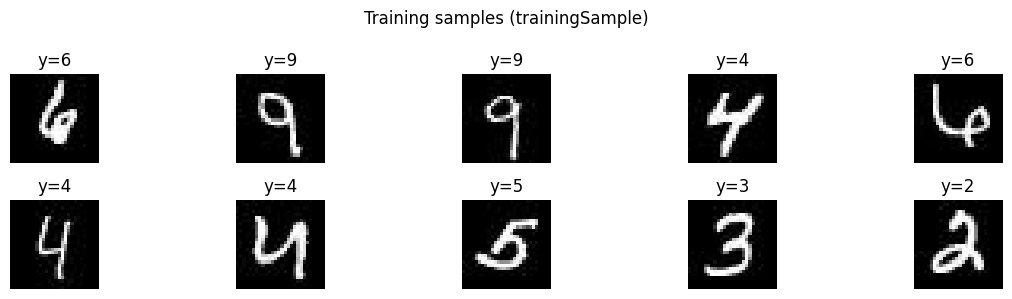

Epoch   1/200 | loss 2.3024 acc 0.1083 | val_loss 2.3036 val_acc 0.0750
Epoch  10/200 | loss 2.3000 acc 0.1500 | val_loss 2.3099 val_acc 0.1000
Epoch  20/200 | loss 2.2966 acc 0.1854 | val_loss 2.3131 val_acc 0.1500
Epoch  30/200 | loss 2.2822 acc 0.1479 | val_loss 2.3068 val_acc 0.1250
Epoch  40/200 | loss 2.0914 acc 0.2104 | val_loss 2.1712 val_acc 0.1667
Epoch  50/200 | loss 1.7038 acc 0.4167 | val_loss 1.8336 val_acc 0.4000
Epoch  60/200 | loss 1.1187 acc 0.6354 | val_loss 1.3934 val_acc 0.5250
Epoch  70/200 | loss 0.5105 acc 0.8604 | val_loss 0.8479 val_acc 0.7250
Epoch  80/200 | loss 0.2656 acc 0.9604 | val_loss 0.7010 val_acc 0.8333
Epoch  90/200 | loss 0.1333 acc 0.9812 | val_loss 0.6058 val_acc 0.8083
Epoch 100/200 | loss 0.0740 acc 0.9917 | val_loss 0.5703 val_acc 0.8250
Epoch 110/200 | loss 0.0459 acc 0.9937 | val_loss 0.5620 val_acc 0.8417
Epoch 120/200 | loss 0.0307 acc 0.9958 | val_loss 0.5642 val_acc 0.8417
Epoch 130/200 | loss 0.0217 acc 1.0000 | val_loss 0.5631 val_acc

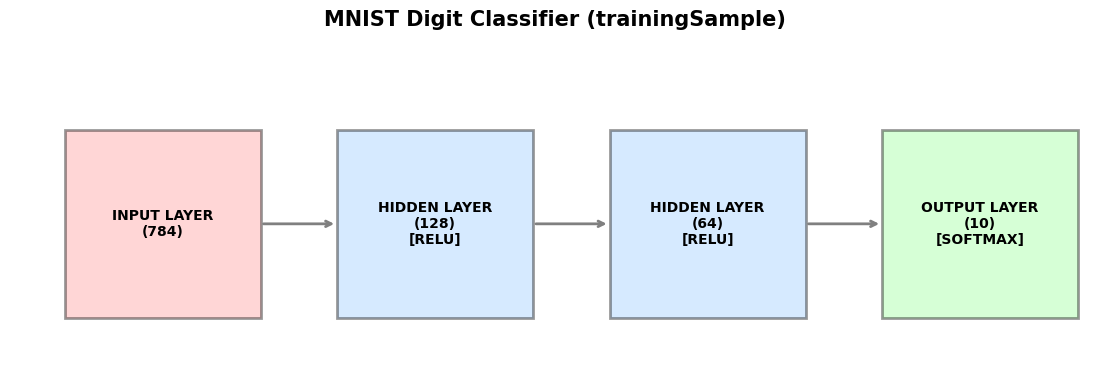

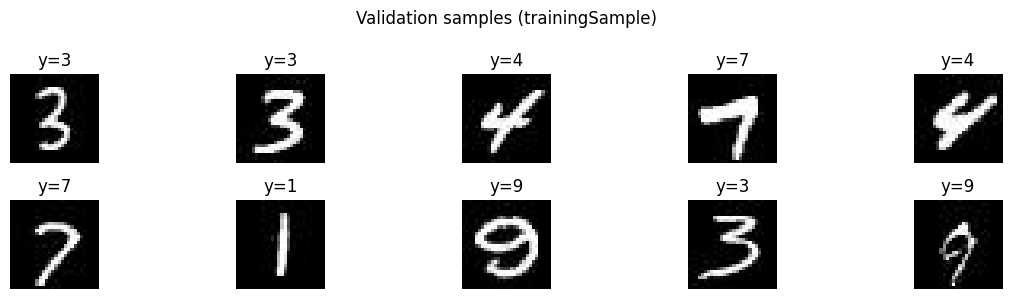

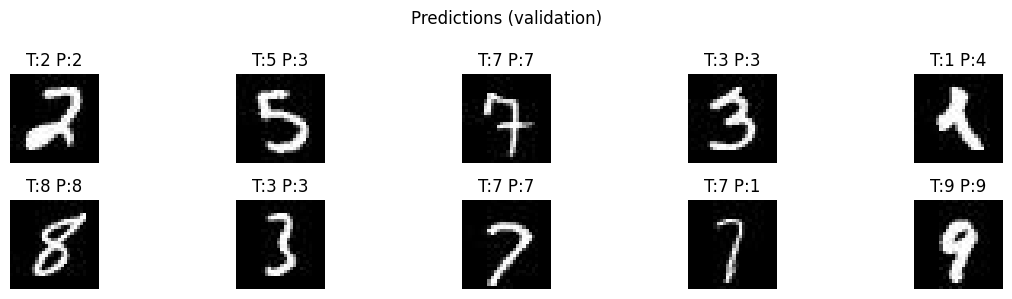


Final train_acc: 1.0000 | Final val_acc: 0.8667


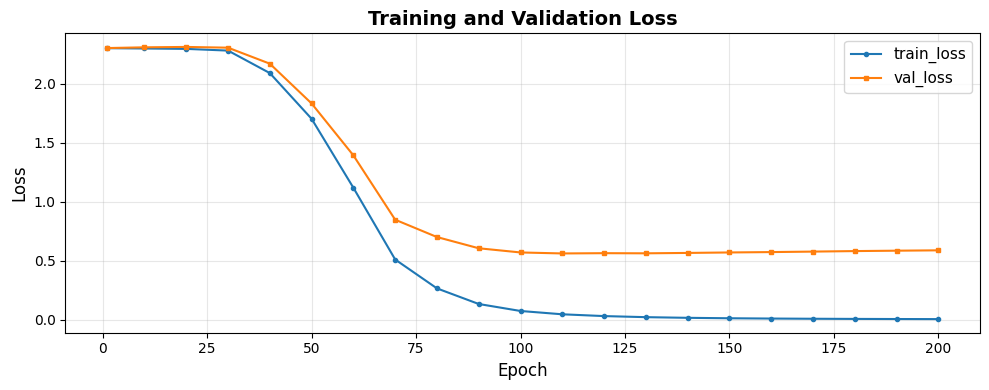

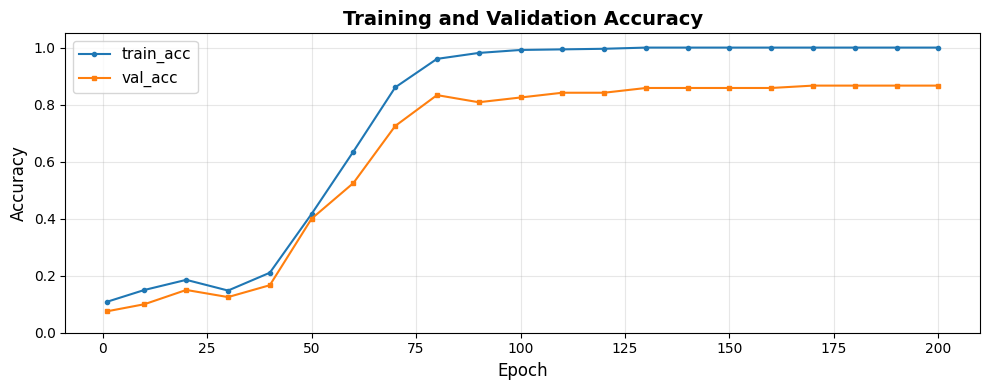


Training Summary:
  Final train_loss: 0.0051
  Final val_loss: 0.5884
  Final train_acc: 1.0000 (100.00%)
  Final val_acc: 0.8667 (86.67%)



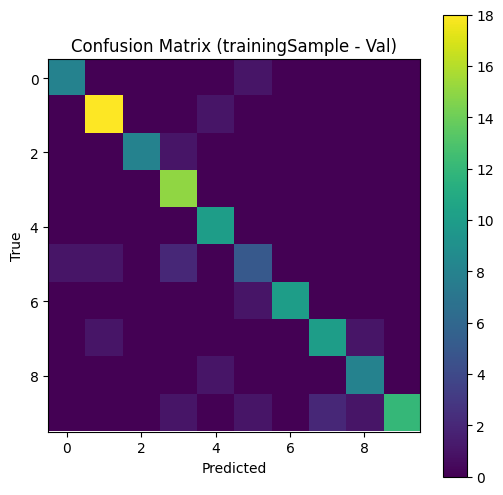

Saved checkpoint to: f:\ANHTHU\1-HCMUS\1 - STUDY\HKVII\DIP\LAB\LAB6\23127266_p06_02\source\custom_mnist_net.pkl
Validation accuracy (loaded): 0.8667
Single image not found: f:\ANHTHU\1-HCMUS\1 - STUDY\HKVII\DIP\LAB\LAB6\23127266_p06_02\source\sample_digit.jpg

Summary: Training Sample Results
Final train_acc: 1.0000 (100.00%)
Final val_acc: 0.8667 (86.67%)


In [174]:
# ==========================================================
# Run: Train + Evaluate (Training Sample)
# ==========================================================
# Chỉ cần truyền CONFIG vào là được!
# CONFIG mặc định đã set split="trainingSample"
print("="*60)
print("Training on Training Sample")
print("="*60)
print(f"Split: {CONFIG['split']}")
print(f"Epochs: {CONFIG['epochs']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Batch size: {CONFIG['batch_size']}")
print("="*60)

results_sample = train_and_evaluate(
    cfg=CONFIG,
    checkpoint_path=CONFIG["save_path"],
    single_image_path=PATHS.get("single_image")
)

# Extract results for backward compatibility
net = results_sample["network"]
history = results_sample["history"]
data = results_sample["data"]

print("\n" + "="*60)
print("Summary: Training Sample Results")
print("="*60)
print(f"Final train_acc: {results_sample['results']['train_acc']:.4f} ({results_sample['results']['train_acc']*100:.2f}%)")
print(f"Final val_acc: {results_sample['results']['val_acc']:.4f} ({results_sample['results']['val_acc']*100:.2f}%)")
print("="*60)


### Training Set

In [171]:
# ==========================================================
# CONFIG for Training Set
# ==========================================================
# Tạo config mới cho trainingSet (toàn bộ training set)
CONFIG_FULL: dict[str, Any] = dict(CONFIG)
CONFIG_FULL["split"] = "trainingSet"  
CONFIG_FULL["epochs"] = 100  
CONFIG_FULL["learning_rate"] = 0.01  
CONFIG_FULL["batch_size"] = 32
CONFIG_FULL["print_every"] = 10
CONFIG_FULL["save_every"] = 10
CONFIG_FULL["save_path"] = os.path.join(os.getcwd(), "custom_mnist_net_full.pkl")

print("="*60)
print("CONFIG for Full Training Set")
print("="*60)
print(f"Split: {CONFIG_FULL['split']}")
print(f"Epochs: {CONFIG_FULL['epochs']}")
print(f"Learning rate: {CONFIG_FULL['learning_rate']}")
print(f"Batch size: {CONFIG_FULL['batch_size']}")
print(f"Save path: {CONFIG_FULL['save_path']}")
print("="*60)


CONFIG for Full Training Set
Split: trainingSet
Epochs: 100
Learning rate: 0.01
Batch size: 32
Save path: f:\ANHTHU\1-HCMUS\1 - STUDY\HKVII\DIP\LAB\LAB6\23127266_p06_02\source\custom_mnist_net_full.pkl



Training on Full Training Set
Split: trainingSet
Epochs: 100
Learning rate: 0.01
Batch size: 32


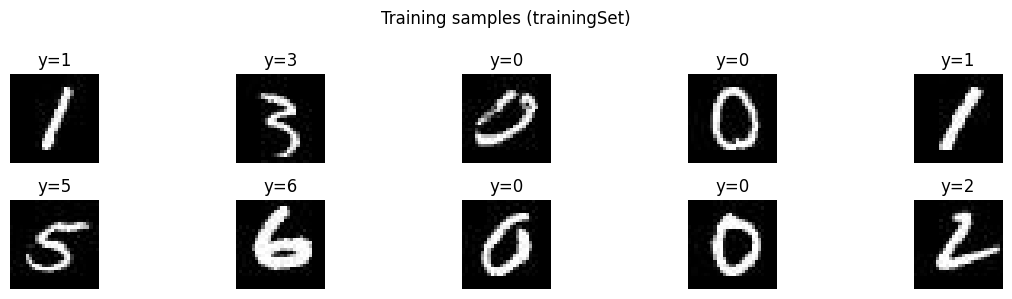

Epoch   1/100 | loss 2.2950 acc 0.1109 | val_loss 2.2947 val_acc 0.1156
Epoch  10/100 | loss 0.1025 acc 0.9710 | val_loss 0.1682 val_acc 0.9506
Epoch  20/100 | loss 0.0311 acc 0.9940 | val_loss 0.1500 val_acc 0.9595
Epoch  30/100 | loss 0.0115 acc 0.9990 | val_loss 0.1628 val_acc 0.9602
Epoch  40/100 | loss 0.0055 acc 0.9999 | val_loss 0.1763 val_acc 0.9606
Epoch  50/100 | loss 0.0031 acc 1.0000 | val_loss 0.1861 val_acc 0.9614
Epoch  60/100 | loss 0.0021 acc 1.0000 | val_loss 0.1939 val_acc 0.9615
Epoch  70/100 | loss 0.0016 acc 1.0000 | val_loss 0.2007 val_acc 0.9613
Epoch  80/100 | loss 0.0012 acc 1.0000 | val_loss 0.2061 val_acc 0.9624
Epoch  90/100 | loss 0.0010 acc 1.0000 | val_loss 0.2107 val_acc 0.9623
Epoch 100/100 | loss 0.0008 acc 1.0000 | val_loss 0.2146 val_acc 0.9625
Network architecture: 784 -> 128 -> 64 -> 10


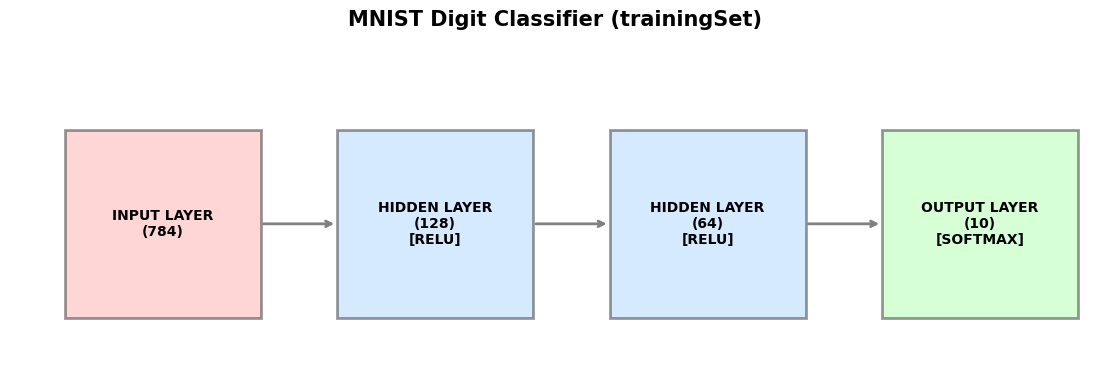

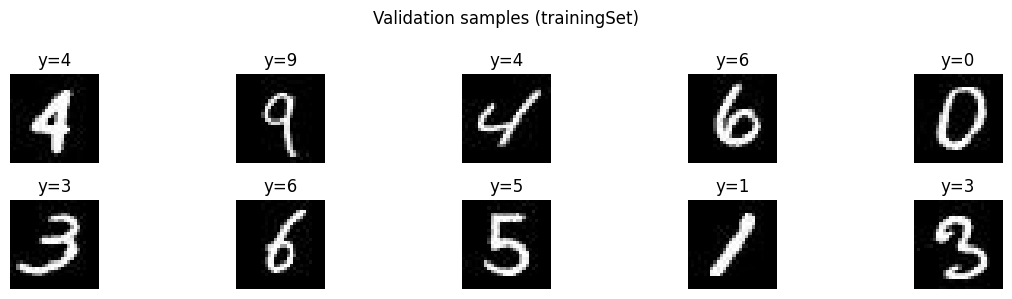

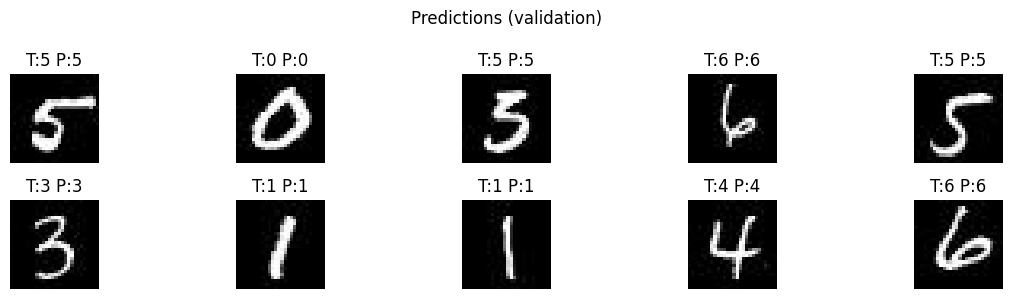


Final train_acc: 1.0000 | Final val_acc: 0.9625


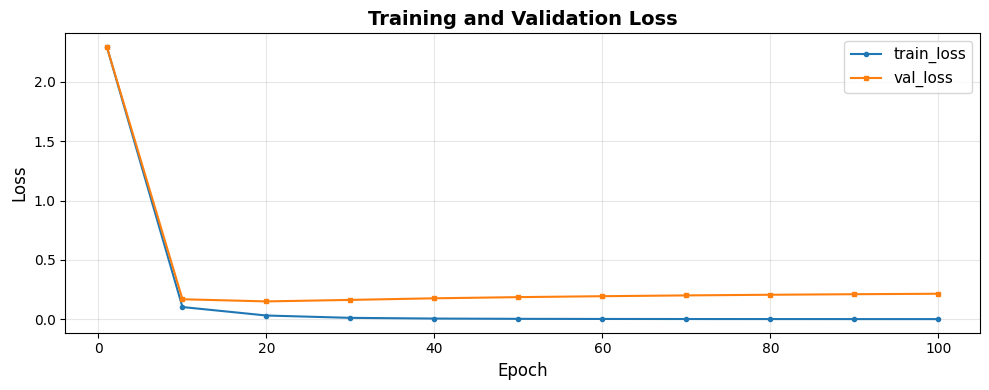

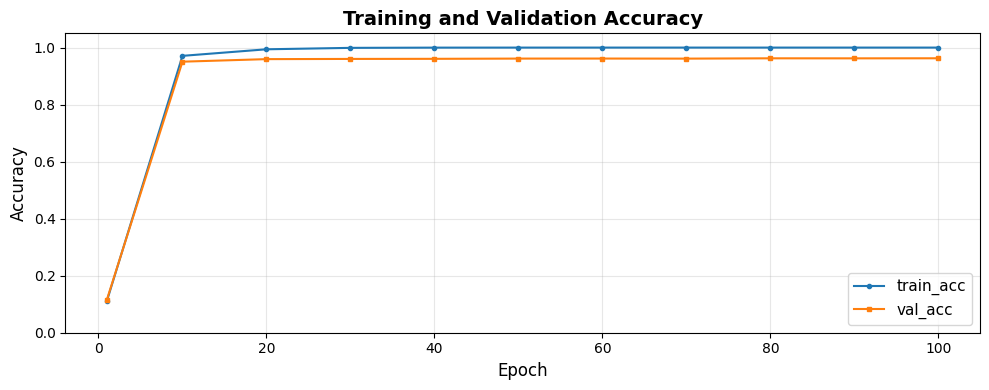


Training Summary:
  Final train_loss: 0.0008
  Final val_loss: 0.2146
  Final train_acc: 1.0000 (100.00%)
  Final val_acc: 0.9625 (96.25%)



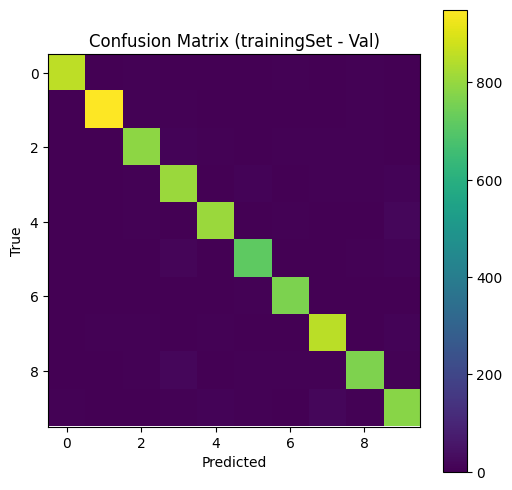

Saved checkpoint to: f:\ANHTHU\1-HCMUS\1 - STUDY\HKVII\DIP\LAB\LAB6\23127266_p06_02\source\custom_mnist_net_full.pkl
Validation accuracy (loaded): 0.9625

Summary: Full Training Set Results
Final train_acc: 1.0000 (100.00%)
Final val_acc: 0.9625 (96.25%)


In [175]:
# ==========================================================
# Training on Full Training Set
# ==========================================================

print("\n" + "="*60)
print("Training on Full Training Set")
print("="*60)
print(f"Split: {CONFIG_FULL['split']}")
print(f"Epochs: {CONFIG_FULL['epochs']}")
print(f"Learning rate: {CONFIG_FULL['learning_rate']}")
print(f"Batch size: {CONFIG_FULL['batch_size']}")
print("="*60)

results_full = train_and_evaluate(
    cfg=CONFIG_FULL,
    checkpoint_path=CONFIG_FULL["save_path"],
    single_image_path=None  
)

# Extract results
net_full = results_full["network"]
history_full = results_full["history"]
data_full = results_full["data"]

print("\n" + "="*60)
print("Summary: Full Training Set Results")
print("="*60)
print(f"Final train_acc: {results_full['results']['train_acc']:.4f} ({results_full['results']['train_acc']*100:.2f}%)")
print(f"Final val_acc: {results_full['results']['val_acc']:.4f} ({results_full['results']['val_acc']*100:.2f}%)")
print("="*60)

In [188]:
def collect_test_images(dataset_root: str, split: str = "testSet") -> list[str]:
    """Collect image file paths from testSet (no labels).
    
    Args:
        dataset_root: Root directory of the dataset.
        split: Split name, default "testSet".
        
    Returns:
        list[str]: List of image file paths.
        
    Raises:
        FileNotFoundError: If testSet directory is not found.
    """
    dataset_root = os.path.abspath(dataset_root)
    split_dir = _resolve_split_dir(dataset_root, split)
    
    # Check if testSet has subfolders (0..9) or just images directly
    paths: list[str] = []
    
    # First, try to collect from subfolders (like trainingSet structure)
    for name in sorted(os.listdir(split_dir)):
        try:
            label = int(name)
            if 0 <= label <= 9:
                label_dir = os.path.join(split_dir, name)
                if os.path.isdir(label_dir):
                    for fn in os.listdir(label_dir):
                        low = fn.lower()
                        if low.endswith(".jpg") or low.endswith(".jpeg") or low.endswith(".png"):
                            paths.append(os.path.join(label_dir, fn))
        except ValueError:
            # Not a digit folder, might be direct image files
            pass
    
    # If no images found in subfolders, try direct files in split_dir
    if len(paths) == 0:
        for fn in os.listdir(split_dir):
            low = fn.lower()
            if low.endswith(".jpg") or low.endswith(".jpeg") or low.endswith(".png"):
                file_path = os.path.join(split_dir, fn)
                if os.path.isfile(file_path):
                    paths.append(file_path)
    
    if len(paths) == 0:
        raise FileNotFoundError(f"No images found in: {split_dir}")
    
    return sorted(paths)


def visualize_test_images(net: Network, paths: list[str], mean: np.ndarray, std: np.ndarray, 
                         num_show: int = 10, device: str = "cpu", title: str = "Test Set Images") -> None:
    """Visualize test images with predictions.
    
    Args:
        net: Trained network.
        paths: List of image file paths.
        mean: Normalization mean (1, 784).
        std: Normalization std (1, 784).
        num_show: Number of images to show.
        device: Device string.
        title: Plot title.
        
    Returns:
        None
        
    Raises:
        ValueError: If paths is empty.
    """
    if len(paths) == 0:
        raise ValueError("paths is empty")
    
    n = min(num_show, len(paths))
    picks = np.random.choice(np.arange(len(paths)), size=n, replace=False)
    
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(picks):
        img = _read_grayscale_28x28(paths[idx])
        x = img.reshape(1, -1).astype(np.float32)
        x = (x - mean) / std
        X = torch.tensor(x, dtype=torch.float32, device=torch.device(device))
        
        with torch.no_grad():
            probs = net.predict(X)  # Output is already probabilities (from softmax)
            pred = int(torch.argmax(probs, dim=1).item())
            conf = float(probs[0, pred].item())
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Pred: {pred}\nConf: {conf:.2f}", fontsize=10)
    
    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


# ==========================================================
# Load Model from "Training on Full Training Set"
# ==========================================================
checkpoint_path = CONFIG_FULL["save_path"]
print("="*60)
print("Loading Model from Full Training Set")
print("="*60)
print(f"Checkpoint path: {checkpoint_path}")

# Load checkpoint
loaded_checkpoint = load_checkpoint(checkpoint_path)
loaded_net = loaded_checkpoint["network"]
loaded_config = loaded_checkpoint["config"]

print(f"Model loaded successfully!")
print(f"Architecture: {describe_network(loaded_net)}")
print("="*60)


Loading Model from Full Training Set
Checkpoint path: f:\ANHTHU\1-HCMUS\1 - STUDY\HKVII\DIP\LAB\LAB6\23127266_p06_02\source\custom_mnist_net_full.pkl
Model loaded successfully!
Network architecture: 784 -> 128 -> 64 -> 10
Architecture: [784, 128, 64, 10]


Found 28000 images in testSet
First 5 paths: ['f:\\ANHTHU\\1-HCMUS\\1 - STUDY\\HKVII\\DIP\\LAB\\LAB6\\23127266_p06_01\\source\\mnistasjpg_data\\testSet\\testSet\\img_1.jpg', 'f:\\ANHTHU\\1-HCMUS\\1 - STUDY\\HKVII\\DIP\\LAB\\LAB6\\23127266_p06_01\\source\\mnistasjpg_data\\testSet\\testSet\\img_10.jpg', 'f:\\ANHTHU\\1-HCMUS\\1 - STUDY\\HKVII\\DIP\\LAB\\LAB6\\23127266_p06_01\\source\\mnistasjpg_data\\testSet\\testSet\\img_100.jpg', 'f:\\ANHTHU\\1-HCMUS\\1 - STUDY\\HKVII\\DIP\\LAB\\LAB6\\23127266_p06_01\\source\\mnistasjpg_data\\testSet\\testSet\\img_1000.jpg', 'f:\\ANHTHU\\1-HCMUS\\1 - STUDY\\HKVII\\DIP\\LAB\\LAB6\\23127266_p06_01\\source\\mnistasjpg_data\\testSet\\testSet\\img_10000.jpg']

Using normalization stats from data_full
Mean shape: (1, 784), Std shape: (1, 784)

Visualizing 10 random images from testSet...


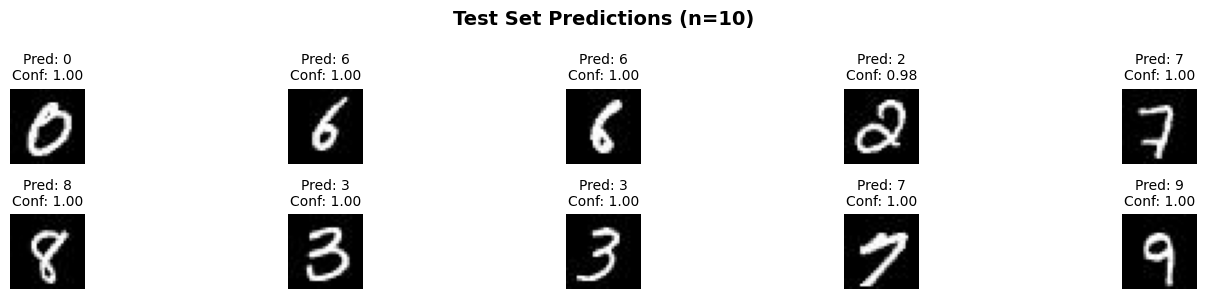

In [190]:
# ==========================================================
# Load and Visualize Test Set Images
# ==========================================================
# Collect images from testSet (no labels)
test_paths = collect_test_images(
    dataset_root=CONFIG["dataset_root"],
    split="testSet"
)

print(f"Found {len(test_paths)} images in testSet")
print(f"First 5 paths: {test_paths[:5]}")

# Get normalization stats from training
# Option 1: Use mean/std from data_full if available (from cell 21)
# Option 2: Recompute from trainingSet with small val_split
if 'data_full' in globals() and data_full is not None:
    # Use existing mean/std from full training
    mean = data_full["mean"]
    std = data_full["std"]
    print(f"\nUsing normalization stats from data_full")
else:
    # Recompute from trainingSet with small val_split to avoid empty val set
    temp_cfg = dict(CONFIG_FULL)
    temp_cfg["split"] = "trainingSet"
    temp_cfg["val_split"] = 0.01  # Small split to ensure at least 1 validation sample
    temp_data = load_mnist_from_image_folders(temp_cfg)
    mean = temp_data["mean"]
    std = temp_data["std"]
    print(f"\nRecomputed normalization stats from trainingSet")

print(f"Mean shape: {mean.shape}, Std shape: {std.shape}")

# Visualize n images (default n=10, can be changed)
n_images = 10
print(f"\nVisualizing {n_images} random images from testSet...")
visualize_test_images(
    net=loaded_net,
    paths=test_paths,
    mean=mean,
    std=std,
    num_show=n_images,
    device=str(CONFIG["device"]),
    title=f"Test Set Predictions (n={n_images})"
)


### Experiment
Config layer, hidden sizes, batch-size, normalize

In [182]:
# Base config template for experiments
def create_experiment_config(layers, batch_size, normalize_mode="standardize"):
    """Create training config from experiment parameters.
    
    Args:
        layers (list): List of hidden layer sizes, e.g. [256, 128]
        batch_size (int): Batch size for training
        normalize_mode (str): Normalization mode - "none" | "center" | "standardize"
        
    Returns:
        dict: Complete training configuration
    """
    return {
        # Reproducibility
        "seed": 42,
        "device": "cpu",
        
        # Data (image folder format like p06_01)
        "dataset_root": PATHS["dataset_root"],
        "split": "trainingSet",  
        "input_size": 784,
        "output_size": 10,
        "val_split": 0.2,
        "shuffle": True,
        "normalize_mode": normalize_mode,
        "eps": 1e-6,
        
        # Model (required)
        "hidden_layers": layers,
        "hidden_activation": "relu",
        "init_std": 0.01,
        
        # Training
        "epochs": 200,
        "batch_size": batch_size,
        "learning_rate": 0.05,
        "print_every": 10,
        "save_every": 10,
        
        # Persistence
        "save_path": None,  # No need to save
    }

# Global results dictionary to store all experiment results
if 'results_dict' not in globals():
    results_dict = {}

In [183]:
# ==========================================
# BLOCK 1: A1_good_2layer_256_128
# ==========================================
config_name = "A1_good_2layer_256_128"
config = create_experiment_config(
    layers=[256, 128],
    batch_size=64,
    normalize_mode="standardize"
)

print("=" * 60)
print(f"Training {config_name}")
print(f"Layers: {config['hidden_layers']}")
print(f"Batch size: {config['batch_size']}")
print(f"Normalize mode: {config['normalize_mode']}")
print("=" * 60)

# Train using train_digit_classifier (no visualization)
result = train_digit_classifier(cfg=config)

# Store results
results_dict[config_name] = {
    "config": config,
    "train_acc": result["history"]["train_acc"][-1],
    "val_acc": result["history"]["val_acc"][-1],
    "layers": config["hidden_layers"],
    "batch_size": config["batch_size"],
    "normalize_mode": config["normalize_mode"]
}

print(f"Train Accuracy: {result['history']['train_acc'][-1]:.6f}")
print(f"Validation Accuracy: {result['history']['val_acc'][-1]:.6f}")
print()


Training A1_good_2layer_256_128
Layers: [256, 128]
Batch size: 64
Normalize mode: standardize
Epoch   1/200 | loss 0.4207 acc 0.8828 | val_loss 0.4280 val_acc 0.8783
Epoch  10/200 | loss 0.0216 acc 0.9967 | val_loss 0.1546 val_acc 0.9627
Epoch  20/200 | loss 0.0027 acc 1.0000 | val_loss 0.1651 val_acc 0.9657
Epoch  30/200 | loss 0.0012 acc 1.0000 | val_loss 0.1783 val_acc 0.9668
Epoch  40/200 | loss 0.0007 acc 1.0000 | val_loss 0.1871 val_acc 0.9670
Epoch  50/200 | loss 0.0005 acc 1.0000 | val_loss 0.1928 val_acc 0.9674
Epoch  60/200 | loss 0.0004 acc 1.0000 | val_loss 0.1978 val_acc 0.9669
Epoch  70/200 | loss 0.0003 acc 1.0000 | val_loss 0.2016 val_acc 0.9673
Epoch  80/200 | loss 0.0003 acc 1.0000 | val_loss 0.2050 val_acc 0.9671
Epoch  90/200 | loss 0.0002 acc 1.0000 | val_loss 0.2079 val_acc 0.9673
Epoch 100/200 | loss 0.0002 acc 1.0000 | val_loss 0.2104 val_acc 0.9675
Epoch 110/200 | loss 0.0002 acc 1.0000 | val_loss 0.2126 val_acc 0.9676
Epoch 120/200 | loss 0.0001 acc 1.0000 | v

In [184]:
# ==========================================
# BLOCK 2: A2_strong_3layer_512_256_128
# ==========================================
config_name = "A2_strong_3layer_512_256_128"
config = create_experiment_config(
    layers=[512, 256, 128],
    batch_size=32,
    normalize_mode="standardize"
)

print("=" * 60)
print(f"Training {config_name}")
print(f"Layers: {config['hidden_layers']}")
print(f"Batch size: {config['batch_size']}")
print(f"Normalize mode: {config['normalize_mode']}")
print("=" * 60)

# Train using train_digit_classifier (no visualization)
result = train_digit_classifier(cfg=config, )

# Store results
results_dict[config_name] = {
    "config": config,
    "train_acc": result["history"]["train_acc"][-1],
    "val_acc": result["history"]["val_acc"][-1],
    "layers": config["hidden_layers"],
    "batch_size": config["batch_size"],
    "normalize_mode": config["normalize_mode"]
}

print(f"Train Accuracy: {result['history']['train_acc'][-1]:.6f}")
print(f"Validation Accuracy: {result['history']['val_acc'][-1]:.6f}")
print()


Training A2_strong_3layer_512_256_128
Layers: [512, 256, 128]
Batch size: 32
Normalize mode: standardize
Epoch   1/200 | loss 1.3623 acc 0.4732 | val_loss 1.3533 val_acc 0.4771
Epoch  10/200 | loss 0.0072 acc 0.9982 | val_loss 0.1993 val_acc 0.9606
Epoch  20/200 | loss 0.0002 acc 1.0000 | val_loss 0.2156 val_acc 0.9637
Epoch  30/200 | loss 0.0001 acc 1.0000 | val_loss 0.2304 val_acc 0.9644
Epoch  40/200 | loss 0.0001 acc 1.0000 | val_loss 0.2395 val_acc 0.9642
Epoch  50/200 | loss 0.0000 acc 1.0000 | val_loss 0.2459 val_acc 0.9644
Epoch  60/200 | loss 0.0000 acc 1.0000 | val_loss 0.2511 val_acc 0.9644
Epoch  70/200 | loss 0.0000 acc 1.0000 | val_loss 0.2553 val_acc 0.9642
Epoch  80/200 | loss 0.0000 acc 1.0000 | val_loss 0.2590 val_acc 0.9643
Epoch  90/200 | loss 0.0000 acc 1.0000 | val_loss 0.2620 val_acc 0.9644
Epoch 100/200 | loss 0.0000 acc 1.0000 | val_loss 0.2648 val_acc 0.9644
Epoch 110/200 | loss 0.0000 acc 1.0000 | val_loss 0.2673 val_acc 0.9644
Epoch 120/200 | loss 0.0000 acc

In [185]:
# ==========================================
# BLOCK 3: B1_batch_32
# ==========================================
config_name = "B1_batch_32"
config = create_experiment_config(
    layers=[256, 128],
    batch_size=32,
    normalize_mode="standardize"
)

print("=" * 60)
print(f"Training {config_name}")
print(f"Layers: {config['hidden_layers']}")
print(f"Batch size: {config['batch_size']}")
print(f"Normalize mode: {config['normalize_mode']}")
print("=" * 60)

# Train using train_digit_classifier (no visualization)
result = train_digit_classifier(cfg=config)

# Store results
results_dict[config_name] = {
    "config": config,
    "train_acc": result["history"]["train_acc"][-1],
    "val_acc": result["history"]["val_acc"][-1],
    "layers": config["hidden_layers"],
    "batch_size": config["batch_size"],
    "normalize_mode": config["normalize_mode"]
}

print(f"Train Accuracy: {result['history']['train_acc'][-1]:.6f}")
print(f"Validation Accuracy: {result['history']['val_acc'][-1]:.6f}")
print()


Training B1_batch_32
Layers: [256, 128]
Batch size: 32
Normalize mode: standardize
Epoch   1/200 | loss 0.2131 acc 0.9360 | val_loss 0.2381 val_acc 0.9281
Epoch  10/200 | loss 0.0056 acc 0.9997 | val_loss 0.1635 val_acc 0.9670
Epoch  20/200 | loss 0.0015 acc 1.0000 | val_loss 0.1845 val_acc 0.9681
Epoch  30/200 | loss 0.0012 acc 1.0000 | val_loss 0.1955 val_acc 0.9681
Epoch  40/200 | loss 0.0011 acc 1.0000 | val_loss 0.2031 val_acc 0.9685
Epoch  50/200 | loss 0.0010 acc 1.0000 | val_loss 0.2083 val_acc 0.9686
Epoch  60/200 | loss 0.0010 acc 1.0000 | val_loss 0.2127 val_acc 0.9686
Epoch  70/200 | loss 0.0009 acc 1.0000 | val_loss 0.2160 val_acc 0.9686
Epoch  80/200 | loss 0.0009 acc 1.0000 | val_loss 0.2191 val_acc 0.9687
Epoch  90/200 | loss 0.0009 acc 1.0000 | val_loss 0.2217 val_acc 0.9688
Epoch 100/200 | loss 0.0009 acc 1.0000 | val_loss 0.2240 val_acc 0.9689
Epoch 110/200 | loss 0.0009 acc 1.0000 | val_loss 0.2260 val_acc 0.9688
Epoch 120/200 | loss 0.0009 acc 1.0000 | val_loss 0.2

In [186]:
# ==========================================
# BLOCK 4: B2_batch_128
# ==========================================
config_name = "B2_batch_128"
config = create_experiment_config(
    layers=[256, 128],
    batch_size=128,
    normalize_mode="standardize"
)

print("=" * 60)
print(f"Training {config_name}")
print(f"Layers: {config['hidden_layers']}")
print(f"Batch size: {config['batch_size']}")
print(f"Normalize mode: {config['normalize_mode']}")
print("=" * 60)

# Train using train_digit_classifier (no visualization)
result = train_digit_classifier(cfg=config)

# Store results
results_dict[config_name] = {
    "config": config,
    "train_acc": result["history"]["train_acc"][-1],
    "val_acc": result["history"]["val_acc"][-1],
    "layers": config["hidden_layers"],
    "batch_size": config["batch_size"],
    "normalize_mode": config["normalize_mode"]
}

print(f"Train Accuracy: {result['history']['train_acc'][-1]:.6f}")
print(f"Validation Accuracy: {result['history']['val_acc'][-1]:.6f}")
print()


Training B2_batch_128
Layers: [256, 128]
Batch size: 128
Normalize mode: standardize
Epoch   1/200 | loss 1.7685 acc 0.4858 | val_loss 1.7604 val_acc 0.4929
Epoch  10/200 | loss 0.0616 acc 0.9836 | val_loss 0.1434 val_acc 0.9570
Epoch  20/200 | loss 0.0150 acc 0.9982 | val_loss 0.1414 val_acc 0.9636
Epoch  30/200 | loss 0.0052 acc 0.9998 | val_loss 0.1542 val_acc 0.9639
Epoch  40/200 | loss 0.0027 acc 1.0000 | val_loss 0.1648 val_acc 0.9645
Epoch  50/200 | loss 0.0017 acc 1.0000 | val_loss 0.1715 val_acc 0.9650
Epoch  60/200 | loss 0.0012 acc 1.0000 | val_loss 0.1775 val_acc 0.9652
Epoch  70/200 | loss 0.0009 acc 1.0000 | val_loss 0.1823 val_acc 0.9650
Epoch  80/200 | loss 0.0007 acc 1.0000 | val_loss 0.1865 val_acc 0.9654
Epoch  90/200 | loss 0.0006 acc 1.0000 | val_loss 0.1900 val_acc 0.9655
Epoch 100/200 | loss 0.0005 acc 1.0000 | val_loss 0.1931 val_acc 0.9655
Epoch 110/200 | loss 0.0004 acc 1.0000 | val_loss 0.1956 val_acc 0.9655
Epoch 120/200 | loss 0.0004 acc 1.0000 | val_loss 0

In [187]:
# Summary comparison table
print("=" * 80)
print("SUMMARY - EXPERIMENT RESULTS COMPARISON")
print("=" * 80)
print()

# Format layers as string
def format_layers(layers):
    return " -> ".join(map(str, layers))

# Print header
print(f"{'Config':<35} {'Layers':<25} {'Batch Size':<12} {'Train Acc':<12} {'Val Acc':<12}")
print("-" * 80)

# Print results
for config_name in ["A1_good_2layer_256_128", "A2_strong_3layer_512_256_128", 
                    "B1_batch_32", "B2_batch_128"]:
    if config_name in results_dict:
        r = results_dict[config_name]
        layers_str = format_layers(r["layers"])
        print(f"{config_name:<35} {layers_str:<25} {r['batch_size']:<12} "
              f"{r['train_acc']:<12.6f} {r['val_acc']:<12.6f}")

print()
print("=" * 80)
print("Conclusion:")
print(f"- Best config (Validation Accuracy): ", end="")
best_val = max([r["val_acc"] for r in results_dict.values()])
best_config = [name for name, r in results_dict.items() if r["val_acc"] == best_val][0]
print(f"{best_config} with val_acc={best_val:.6f}")
print("=" * 80)


SUMMARY - EXPERIMENT RESULTS COMPARISON

Config                              Layers                    Batch Size   Train Acc    Val Acc     
--------------------------------------------------------------------------------
A1_good_2layer_256_128              256 -> 128                64           1.000000     0.967619    
A2_strong_3layer_512_256_128        512 -> 256 -> 128         32           1.000000     0.964881    
B1_batch_32                         256 -> 128                32           0.999970     0.968571    
B2_batch_128                        256 -> 128                128          1.000000     0.966190    

Conclusion:
- Best config (Validation Accuracy): B1_batch_32 with val_acc=0.968571
